In [1]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper
!apt update && apt install python-opengl ffmpeg
!pip install ufal.pybox2d
!pip install shimmy

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [986 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,173 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [862 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,251 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [981 kB]
Get:13 https://ppa.launchpadco

# 실습 게임 정보

https://gymnasium.farama.org/environments/box2d/lunar_lander/

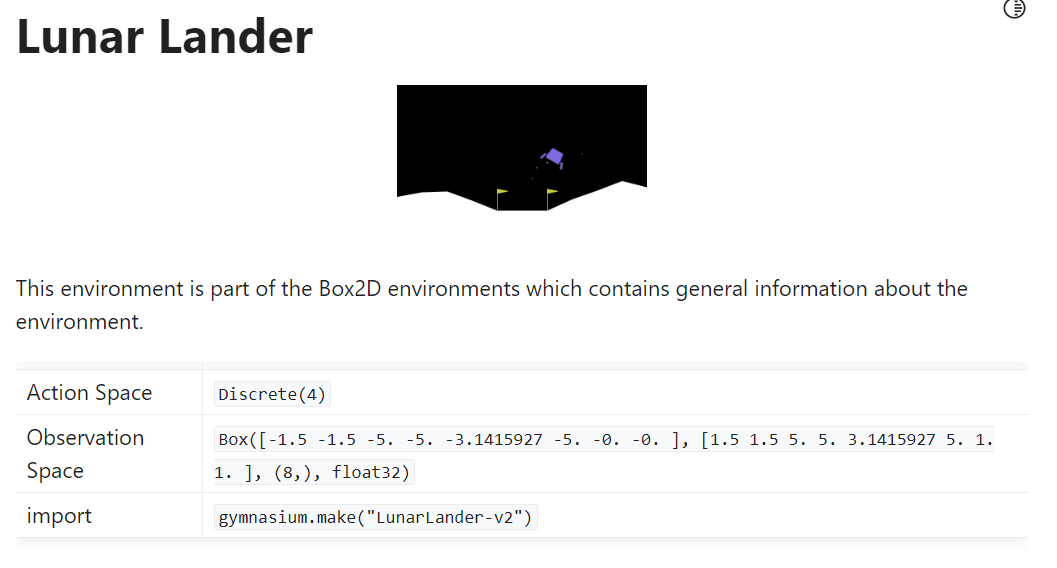

## 코드 출처

https://github.com/seungeunrho/minimalRL

In [3]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []

        self.fc1   = nn.Linear(?,256) # ? 에 들어갈 숫자는?
        self.fc_pi = nn.Linear(256, ?) # ? 에 들어갈 숫자는?
        self.fc_v  = nn.Linear(256,?) # ? 에 들어갈 숫자는?
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])

            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1) # 다시 샘플링
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

In [4]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
model = PPO()
score = 0.0
print_interval = 20

In [ ]:
import gnwrapper
import gym

env = gnwrapper.Monitor(gym.make('LunarLander-v2'),directory="./") # Start Xvfb

for n_epi in range(500):
    s = env.reset()
    done = False
    while not done:
        for t in range(T_horizon):

            prob = model.pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)

            model.put_data((s, a, r, s_prime, prob[a].item(), done))
            s = s_prime

            score += r
            if done:
                env.reset()
                break
        model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        score = 0.0

In [10]:
env.display() # Here, display saved display images as movies

'rl-video-episode-0.mp4'

'rl-video-episode-1.mp4'

'rl-video-episode-1.mp4'

'rl-video-episode-8.mp4'

'rl-video-episode-8.mp4'

'rl-video-episode-8.mp4'

'rl-video-episode-27.mp4'

'rl-video-episode-27.mp4'

'rl-video-episode-27.mp4'

'rl-video-episode-64.mp4'

'rl-video-episode-64.mp4'

'rl-video-episode-64.mp4'

'rl-video-episode-125.mp4'

'rl-video-episode-125.mp4'

'rl-video-episode-125.mp4'

'rl-video-episode-216.mp4'

'rl-video-episode-216.mp4'

'rl-video-episode-216.mp4'

'rl-video-episode-343.mp4'

'rl-video-episode-343.mp4'

'rl-video-episode-343.mp4'